In [25]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches
from IPython.display import display



In [26]:
USE_GPU = True
TRAIN = True

In [27]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724692875.597838   24890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724692875.599505   24890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724692875.601145   24890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724692875.602838   24890 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [28]:
IMAGE_SIZE = 24
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100

In [29]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 22, 24), (2740,), (2740, 24, 24, 1))

In [30]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(24, 24, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 24)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 48)       │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 192)      │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 384)      │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 1, 1)        │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,057 (1.50 MB)

 Trainable params: 394,057 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=3, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=2, strides=1, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 1, 1, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 4, 4, 192)      │     1,769,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 192)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 96)       │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 48)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 24, 24, 24)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 24, 24, 24)     │         9,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │             

 Total params: 2,380,321 (9.08 MB)

 Trainable params: 2,379,649 (9.08 MB)

 Non-trainable params: 672 (2.62 KB)

In [32]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [33]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [34]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/55


I0000 00:00:1724692883.203642   27216 service.cc:146] XLA service 0x7d5238008db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724692883.203661   27216 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-08-26 18:21:23.528983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 18:21:24.555432: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:17 39s/step - c_gp: 0.8320 - c_loss: 8.2070 - c_wass_loss: -0.1125 - g_loss: 0.1784

I0000 00:00:1724692914.505456   27216 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - c_gp: 0.6374 - c_loss: 5.7756 - c_wass_loss: -0.5988 - g_loss: 0.7528  

W0000 00:00:1724692945.374782   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.385503   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.386742   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.387254   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.387767   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.388866   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.389542   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.390066   24890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724692945.390904   24890 gp

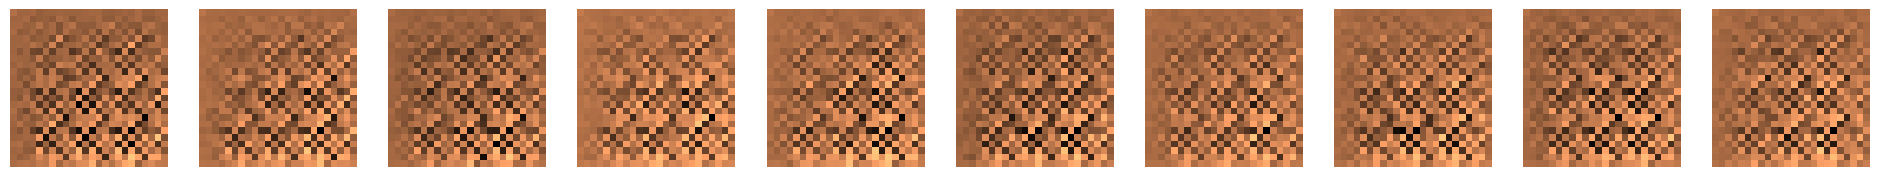

3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 16s/step - c_gp: 0.5922 - c_loss: 5.1531 - c_wass_loss: -0.7694 - g_loss: 0.9545
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - c_gp: 0.1406 - c_loss: -6.8073 - c_wass_loss: -8.2132 - g_loss: 10.6016

2024-08-26 18:22:25.794591: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-26 18:22:25.794631: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 18:22:25.794648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8337064099461681807
/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.3385 - c_loss: -9.3071 - c_wass_loss: -12.6925 - g_loss: 14.0088
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - c_gp: 0.5632 - c_loss: -13.4821 - c_wass_loss: -19.1145 - g_loss: 21.0148

2024-08-26 18:22:26.196316: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.5555 - c_loss: -13.0656 - c_wass_loss: -18.6205 - g_loss: 20.0390
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.5690 - c_loss: -11.8954 - c_wass_loss: -17.5854 - g_loss: 16.6074
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - c_gp: 0.5218 - c_loss: -10.4914 - c_wass_loss: -15.7096 - g_loss: 13.4971

2024-08-26 18:22:26.950133: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 18:22:26.950176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8337064099461681807


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.4869 - c_loss: -10.2782 - c_wass_loss: -15.1474 - g_loss: 12.6673
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.3088 - c_loss: -9.6027 - c_wass_loss: -12.6907 - g_loss: 11.3507

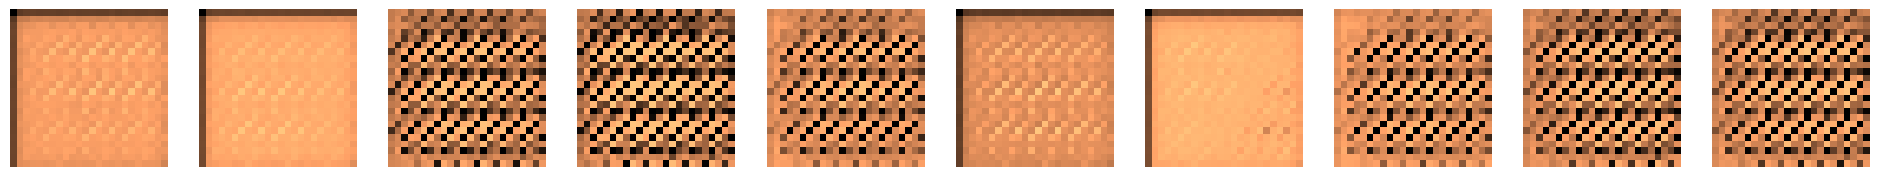

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - c_gp: 0.3028 - c_loss: -9.5692 - c_wass_loss: -12.5973 - g_loss: 11.3002
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - c_gp: 0.2481 - c_loss: -9.1009 - c_wass_loss: -11.5817 - g_loss: 10.6665
Epoch 14/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.1590 - c_loss: -8.5689 - c_wass_loss: -10.1593 - g_loss: 10.2489
Epoch 16/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - c_gp: 0.1605 - c_loss: -8.4016 - c_wass_loss: -10.0062 - g_loss: 9.9030

2024-08-26 18:22:28.568884: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 18:22:28.568912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8337064099461681807


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.1977 - c_loss: -8.3265 - c_wass_loss: -10.3033 - g_loss: 9.6834
Epoch 18/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.2226 - c_loss: -7.9985 - c_wass_loss: -10.2246 - g_loss: 9.7551
Epoch 20/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 21/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.2110 - c_loss: -7.6520 - c_wass_loss: -9.7619 - g_loss: 9.2142

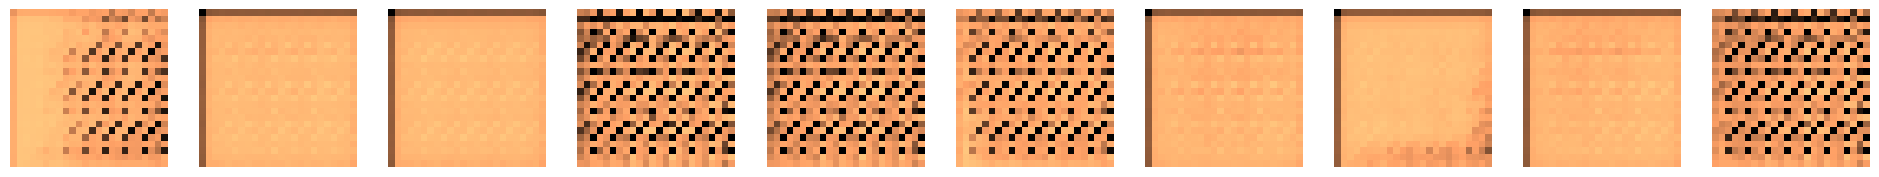

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - c_gp: 0.2098 - c_loss: -7.6317 - c_wass_loss: -9.7297 - g_loss: 9.1805
Epoch 22/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.1294 - c_loss: -7.3476 - c_wass_loss: -8.6412 - g_loss: 9.6690
Epoch 24/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.1462 - c_loss: -7.0956 - c_wass_loss: -8.5577 - g_loss: 9.2720
Epoch 26/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.1601 - c_loss: -6.9527 - c_wass_loss: -8.5537 - g_loss: 8.5445
Epoch 28/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_lo

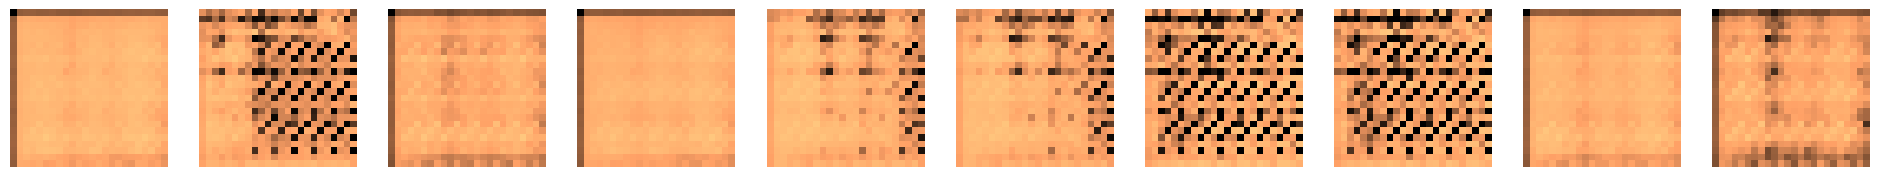

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - c_gp: 0.1457 - c_loss: -6.2311 - c_wass_loss: -7.6876 - g_loss: 7.2123
Epoch 32/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - c_gp: 0.1504 - c_loss: -5.9276 - c_wass_loss: -7.4319 - g_loss: 6.7603

2024-08-26 18:22:31.981457: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.1285 - c_loss: -5.8946 - c_wass_loss: -7.1799 - g_loss: 6.8097
Epoch 34/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.1299 - c_loss: -5.4758 - c_wass_loss: -6.7750 - g_loss: 6.0938
Epoch 36/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.1216 - c_loss: -5.1944 - c_wass_loss: -6.4109 - g_loss: 5.4919
Epoch 38/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 39/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.0808 - c_loss: -4.4458 - c_wass_loss: -5.2537 - g_loss: 5.4654
Epoch 40/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss

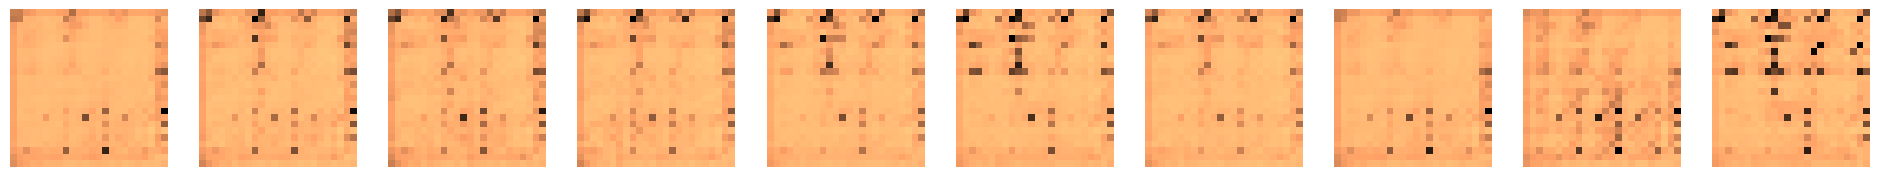

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - c_gp: 0.0673 - c_loss: -3.8542 - c_wass_loss: -4.5276 - g_loss: 4.5094
Epoch 42/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0615 - c_loss: -3.1106 - c_wass_loss: -3.7255 - g_loss: 3.1882
Epoch 44/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0288 - c_loss: -2.4102 - c_wass_loss: -2.6980 - g_loss: 1.8873
Epoch 46/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.0307 - c_loss: -2.0334 - c_wass_loss: -2.3404 - g_loss: 1.2360
Epoch 48/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 

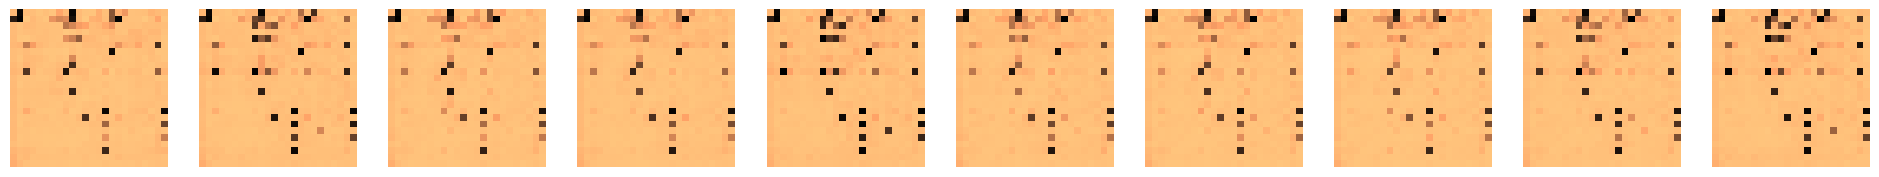

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - c_gp: 0.0156 - c_loss: -1.5381 - c_wass_loss: -1.6943 - g_loss: 1.3476
Epoch 52/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0221 - c_loss: -1.3168 - c_wass_loss: -1.5379 - g_loss: 0.1863   
Epoch 54/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0212 - c_loss: -1.2644 - c_wass_loss: -1.4761 - g_loss: -0.5199


In [35]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(100, 24, 24, 1)


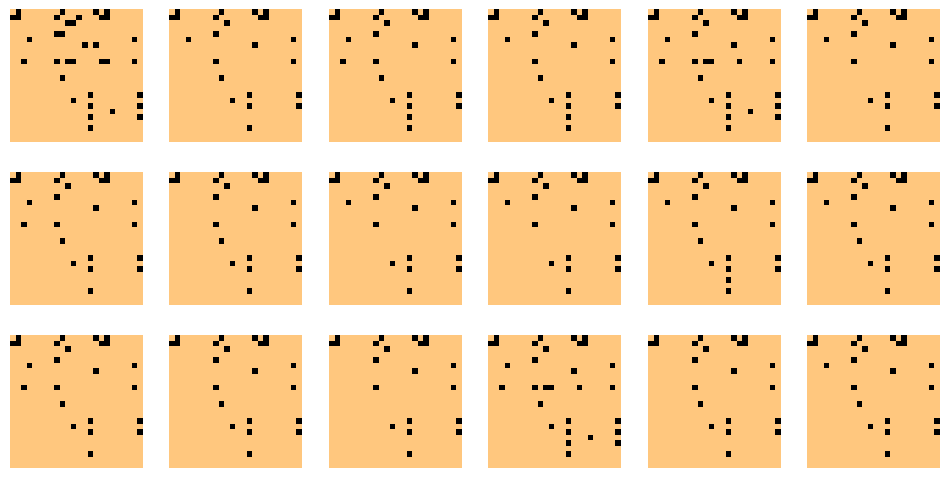

In [38]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_languages = generator.predict(noise)
    l = generated_languages.shape[0]

    # normalise
    generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
    # sigmoid
    generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_languages])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_languages.npz",
        generated_languages=generated_languages,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_languages.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]
    weirdness = data["weirdness"]
    l = generated_languages.shape[0]

print(generated_languages.shape)


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

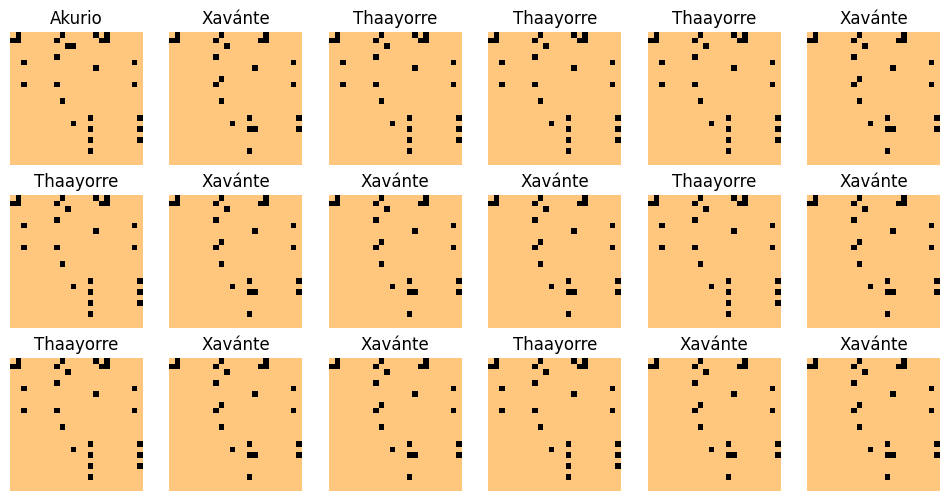

0.007881944444444445

In [39]:
# find closest matches

closest_idx, closest, closest_diff = get_closest_matches(X, generated_languages, n=NUM_LANGS)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

np.mean(closest_diff)

In [40]:
# find exact matches

exact_idx = get_exact_matches(X, generated_languages)
exact = np.take(X, exact_idx)
exact_language_names = np.take(language_names_selected, exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

X.shape, exact_idx.shape

No exact matches. Noice!


((2740, 24, 24, 1), (0,))

In [41]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

((14, 24), (7, 10), (3, 4), (7, 10))

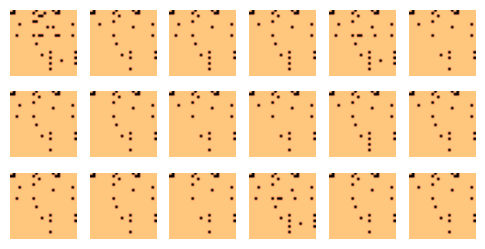

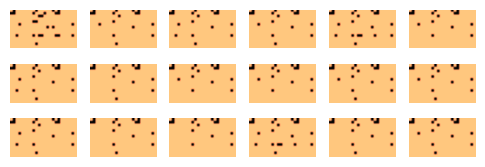

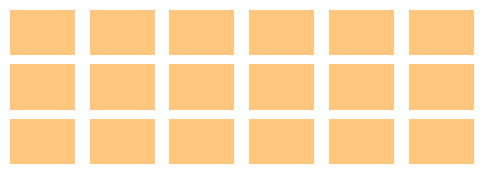

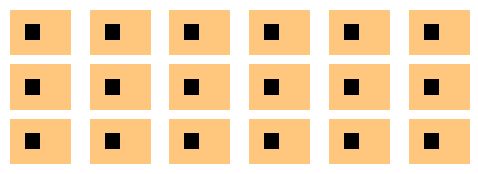

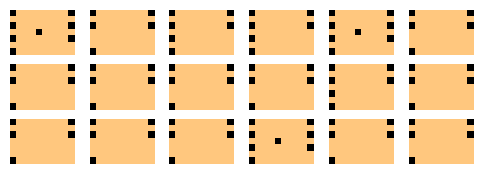

((100, 14, 24, 1), (100, 7, 10, 1), (100, 3, 4, 1), (100, 7, 10, 1))

In [42]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:10 :]
generated_cons_coart = generated_languages[:, 15:18, 10:14 :]
generated_vowels = generated_languages[:, 15:22, 14:24 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(6, 3))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(6, 2))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [44]:
def create_ipa_table(lang, tbl, merge=False):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    if merge is True:
        return pd.DataFrame(
            np.char.add(
                np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " / ")),
                phonemes[:,1::2]
            ), 
            index=tbl.index, 
            columns=tbl.columns[0::2]
        ).replace("_ / _", "")
    else:
        return pd.DataFrame(
            phonemes, 
            index=tbl.index, 
            columns=tbl.columns
        ).replace("_", "")
    
most_different = np.argmax(weirdness)
least_different = np.argmin(weirdness)


for idx in [most_different, least_different]:

    sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[idx]), cons_pl_tbl_df, merge=True)

    display(sample_cons_pl_tbl)

    sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[idx]), cons_npl_tbl_df)

    display(sample_cons_npl_tbl)

    sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[idx]), cons_coart_tbl_df)

    display(sample_cons_coart_tbl)

    sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[idx]), vowels_tbl_df)

    display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ / m,,,,_ / n,,,_ / ɲ,_ / ŋ,,,
Plosive,p / b,,,,t / _,,ʈ / _,,k / ɡ,,,
Sibilant affricate,,,,,,t̠ʃ / d̠ʒ,,,,,,
Non-sibilant affricate,,,,,,,,,,,,
Sibilant fricative,,,,,s / z,,,,,,,
Non-sibilant fricative,,_ / v,,,,,,,,,,h / _
Approximant,,,,,,,_ / ɻ,_ / j,,,,
Tap/flap,,,,,,,,,,,,
Trill,,,,,,,,,,,,
Fricative,,f / _,,,s / _,ʃ / ʒ,,,x / ɣ,,,h / _


,Bilabial,Labiodental,Dental,Alveolar,Palato-alveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal
Ejective Stop,,,,,,,,,,
Ejective Fricative,,,,,,,,,,
Ejective Affricate,,,,,,,,,,
Ejective Lateral,,,,,,,,,,
Click,,,,,,,,,,
Implosive Voiced,,,,,,,,,,
Implosive Voiceless,,,,,,,,,,


,Labial–palatal,Labial–velar,Velarized alveolar,Palatal-velar
Fricative,,,,
Approximant,,w,,
Lateral approximant,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,,,,,,,,,u
Near-close,,,,,,,,,,
Close-mid,e,,,,,,,,,o
Mid,,,,,ə,,,,,
Open-mid,ɛ,,,,,,,,,ɔ
Near-open,,,,,,,,,,
Open,a,,,,,,,,,


,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ / m,,,,_ / n,,,_ / ɲ,_ / ŋ,,,
Plosive,p / b,,,,t / _,,,,k / ɡ,,,
Sibilant affricate,,,,,,t̠ʃ / _,,,,,,
Non-sibilant affricate,,,,,,,,,,,,
Sibilant fricative,,,,,s / _,,,,,,,
Non-sibilant fricative,,,,,,,,,,,,h / _
Approximant,,,,,,,,_ / j,,,,
Tap/flap,,,,,,,,,,,,
Trill,,,,,,,,,,,,
Fricative,,,,,s / _,,,,,,,h / _


,Bilabial,Labiodental,Dental,Alveolar,Palato-alveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal
Ejective Stop,,,,,,,,,,
Ejective Fricative,,,,,,,,,,
Ejective Affricate,,,,,,,,,,
Ejective Lateral,,,,,,,,,,
Click,,,,,,,,,,
Implosive Voiced,,,,,,,,,,
Implosive Voiceless,,,,,,,,,,


,Labial–palatal,Labial–velar,Velarized alveolar,Palatal-velar
Fricative,,,,
Approximant,,w,,
Lateral approximant,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,,,,,,,,,u
Near-close,,,,,,,,,,
Close-mid,e,,,,,,,,,o
Mid,,,,,,,,,,
Open-mid,,,,,,,,,,
Near-open,,,,,,,,,,
Open,a,,,,,,,,,
